In [1]:
#!/usr/bin/env python
import numpy as np
from scipy.sparse import csr_matrix
from scipy.integrate import ode
import timeit
import argparse
import sys
from progressbar import *
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import networkx as nx

In [2]:
def rates(X,eta,nu,k):
    return k*np.product(X**nu,axis=1)

def func(t, X, eta, nu, k):
    return np.sum((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis],axis=0)

def jac(X,eta,nu,k):
    return np.tensordot(np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]),nu/X,axes=1)

def steady(n, t1, dt, eta, nu, k):
    np.random.seed(iseed)
    X0 = np.random.random(n)
    rode=ode(func).set_integrator('lsoda',rtol=1e-3,atol=1e-3,max_step=dt)
    rode.set_initial_value(X0, 0)
    rode.set_f_params(eta, nu, k)
    for n in range(int(t1/dt)):
        t=n*dt
        pbar.update(t)
        X=rode.integrate(rode.t + dt)
        Xs[n] = X
    pbar.finish()
    
def func2(X, eta, nu, k, XD):
    return XD+np.sum((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis],axis=0)
def func3(t, X, eta, nu, k, XD):
    return XD+np.sum((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis],axis=0)
def jac2(X,eta,nu,k,XD):
    return np.tensordot(np.transpose((eta-nu)*rates(X,eta,nu,k)[:,np.newaxis]),nu/X,axes=1)
def steady2(n, t1, dt, eta, nu, k, XD):
    np.random.seed(iseed)
    X0 = np.random.random(n)
    XX=np.zeros((int(t1/dt),n))
    rode=ode(func3).set_integrator('lsoda',rtol=1e-3,atol=1e-3,max_step=dt)
    rode.set_initial_value(X0, 0)
    rode.set_f_params(eta, nu, k, XD)
    for n in range(int(t1/dt)):
        t=n*dt
        pbar.update(t)
        X=rode.integrate(rode.t + dt)
        XX[n] = X
    pbar.finish()
    return XX

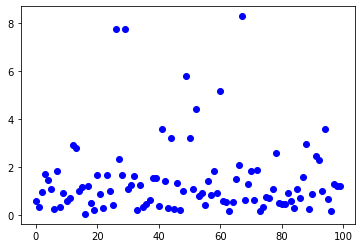

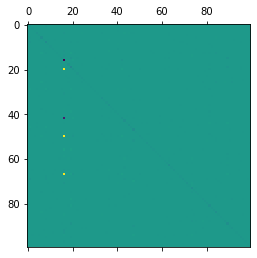

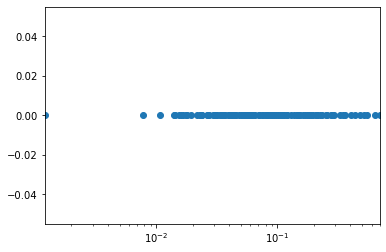

1.3232020903716505e-14 4.4952046736975395e-15


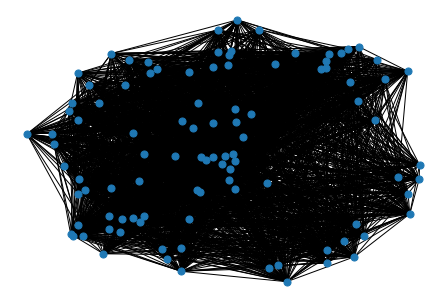

In [3]:
n=100
c=5
nr=int(c*n)

eta=np.zeros((2*nr,n))
nu=np.zeros((2*nr,n))
k=np.zeros(2*nr)
G=np.random.normal(loc=0, scale=1, size=n)


for i in range(nr):
#     nreac=np.random.randint(1,4)
#     nprod=np.random.randint(1,4)
    nreac=2
    nprod=2
    reactants=np.random.choice(np.arange(n),size=np.random.randint(1,4),replace=False)
    products=np.random.choice(np.setdiff1d(np.arange(n),reactants),size=np.random.randint(1,4),replace=False)
    #forward
    eta[2*i,reactants]=1
    nu[2*i,products]=1
    k[2*i]=np.random.random()
    deltaG=np.sum(G[products])-np.sum(G[reactants])
    K=np.exp(-deltaG)
    #reverse
    nu[2*i+1,reactants]=1
    eta[2*i+1,products]=1
    k[2*i+1]=k[2*i]*K
    

Xs=np.exp(-G)
plt.plot(Xs,'bo')
plt.show()
plt.matshow(jac(Xs,eta,nu,k))
plt.show()
evals=np.linalg.eig(jac(np.exp(-G),eta,nu,k))
order=np.argsort(np.abs(-1/np.real(evals[0])))
tau=-1/np.real(evals[0][order[:-1]])
im=np.imag(evals[0][order[:-1]])
plt.xlim(np.min(tau),np.max(tau))
plt.xscale('log')
plt.scatter(x=tau,y=im)
plt.show()
g=nx.from_numpy_matrix(jac(np.exp(-G),eta,nu,k))
nx.draw(g,node_size=50)
r=rates(Xs,eta,nu,k)
print(np.linalg.norm((r[::2]-r[1::2])), np.linalg.norm((r[::2]-r[1::2])/r[::2]))

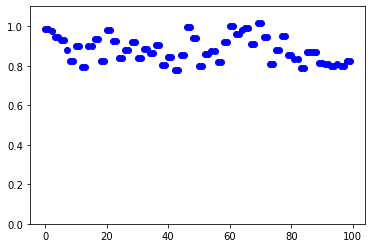

In [5]:
J=jac(np.exp(-G),eta,nu,k)
evals=np.linalg.eig(J)
np.linalg.norm(J@J.transpose()-J.transpose()@J)
plt.ylim(0,1.1)
plt.plot(np.abs(np.linalg.eig(evals[1])[0]),'bo')
plt.plot()
plt.show()

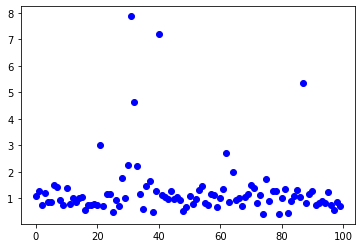

Integration: 100%|##############################################| Time: 0:00:07


Calculated dynamics in  7.638690216999976 seconds


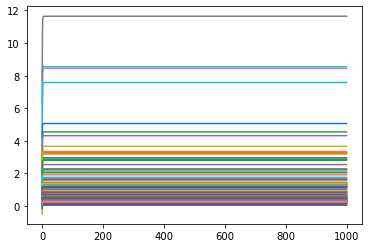

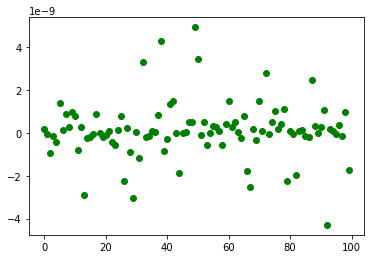

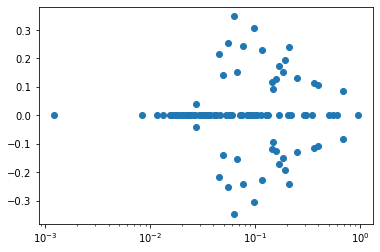

-1.0458916684248596


In [21]:
X0=np.random.normal(size=n)
Xdot=np.random.normal(size=n)
Xdot=Xdot-np.sum(Xdot)/n
drive=3e0
Xs=np.exp(-G)
X0=Xs
Xs2=fsolve(func2,x0=X0,args=(eta,nu,k,drive*Xdot),fprime=jac2)
np.linalg.norm(Xs-Xs2)
plt.plot(Xs/Xs2,'bo')
plt.show()

t1=1000
dt=1
iseed=1
pbar=ProgressBar(widgets=['Integration: ', Percentage(),Bar(), ' ', ETA()], maxval=t1)
pbar.start()
start=timeit.default_timer()
Xs3=steady2(n,t1,dt,eta,nu,k,drive*Xdot)
stop=timeit.default_timer()
print("Calculated dynamics in ", stop-start, "seconds")
plt.plot(Xs3)
plt.show()
plt.plot(Xs3[-1]-Xs2,'go')
plt.show()
evals,evecs=np.linalg.eig(jac2(Xs2,eta,nu,k,drive*Xdot))
plt.xscale('log')
plt.scatter(x=-1/np.real(evals),y=np.imag(evals))
plt.show()
print(np.max(np.real(evals)))

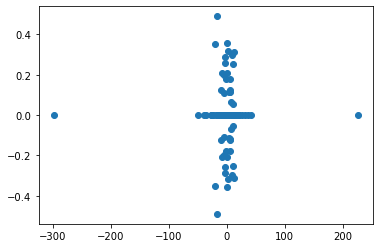

In [22]:
J=jac2(Xs2,eta,nu,k,drive*Xdot)
(evals,evecs)=np.linalg.eig(J-np.diag(np.diagonal(J)))
plt.scatter(x=np.real(evals),y=np.imag(evals))
plt.show()

In [32]:
print(len(np.where(J==0)[0])/n**2,len(np.where(J!=0)[0])/n**2)

0.5008 0.4992


In [37]:
print(len(np.where(J[0]!=0)[0]),len(np.where(J[0]==0)[0]))

46 54
